# Systems Medicine Notebook

This notebook is for the final analysis of the model within my masters project. In many ways it will act as a replacement for the main files since I have made them a bit unwieldy. This is possible as many of the functions are quick to run, on the order of seconds, with only a couple taking longer than a minute or so to run.

In [ ]:
# Import Python packages, classes and functions

import senescence_model as sm
import fibrosis_model as fm
import fibrosis_senescence_model as fsm
import state_parameter_maker as spm

import numpy as np
import time
import scipy.integrate 
import matplotlib.pyplot as plt
import plotting as ping
import matplotlib as mpl

# Higher dpi for plots
mpl.rcParams['figure.dpi'] = 500
mpl.rcParams['savefig.dpi'] = 500

#
## Model without senescence
Here we look at the model without senescence, plots should include nullclines, fixed points, separatrices trajectories in macrophage-myofibroblast space and time series of cell populations

In [2]:
min2day = 24*60 

initial_state = spm.state_fm(10,10,10,10)
initial_params = spm.params_fm(lam1=0.9, lam2=0.8, mu1=0.3, mu2=0.3, K=1e6, k1=1e9,k2=1e9,
                                beta1=470 * min2day,beta2=70 * min2day,beta3=240 * min2day,
                                alpha1=940 *min2day,alpha2=510 *min2day, gamma=2)
sys_1 = fm.fibrosis_model(initial_params,initial_state)

In [3]:
## Extra helpers for plotting, saves space
def logax():
    plt.xscale('log')
    plt.yscale('log')

def plot_fp(ptx,pty,colors,labels):
    for i in range(len(ptx)):
        plt.scatter(ptx[i],pty[i],color=colors[i],label=labels[i])
        print(f'{ptx[i]},{pty[i]},{colors[i]},{labels[i]}')
    plt.xscale('log')
    plt.yscale('log')
def plot_sep(fixed_pts,color='r'):
    t_sep = np.linspace(0,100,1000)
    fp = fixed_pts[3]
    sep_traj = sys_1.separatrix_traj_neg(t_sep,fp,epsilon=0.1),sys_1.separatrix_traj_neg(t_sep,fp,epsilon=-0.1)
    plt.plot(sep_traj[0][1],sep_traj[0][0],color=color)
    plt.plot(sep_traj[1][1],sep_traj[1][0],color=color)
def lims(x=[10**-2,10**7],y=[10**-2,10**7]):
    plt.xlim(x[0], y[1])
    plt.ylim(y[0],y[1])
def plot_trajectories(pulses,X0 = np.array([0, 50]),t = np.linspace(0, 100,  1000),color='maroon',label='Trajectory'):
    X = scipy.integrate.solve_ivp(sys_1.constant_injury,(t[0],t[-1]),X0,t_eval=t,args = (pulses,))
    plt.plot(X.y[1],X.y[0],color=color,label=label)




In [4]:
## FIXED POINTS ##
fixed_pts, meta = sys_1.fixed_pt_sweep([-2, 7], [-2, 7], perturb=True, classify=True)

ptx, pty = [], []
labels = []
colors = []

color_map = {
    "stable (attractor)": "green",
    "unstable (repellor)": "red",
    "saddle (mixed stability)": "orange"
}

for i, (M, F) in enumerate(fixed_pts):
    ptx.append(F)
    pty.append(M)
    if i in meta and 'verdict' in meta[i]:
        label = meta[i]['verdict']
        labels.append(label)
        colors.append(color_map[label])  # Build colors in sync

# # Debug output
# print(ptx, pty)
# print(labels)
# print(colors)


Finished lambda func
stable (attractor)
unstable (repellor)
saddle (mixed stability)
saddle (mixed stability)
stable (attractor)


0.01,0.01,green,stable (attractor)
10339.24,0.01,red,unstable (repellor)
278801.55,0.01,orange,saddle (mixed stability)
5328.84,4741.06,orange,saddle (mixed stability)
481389.27,639488.3,green,stable (attractor)


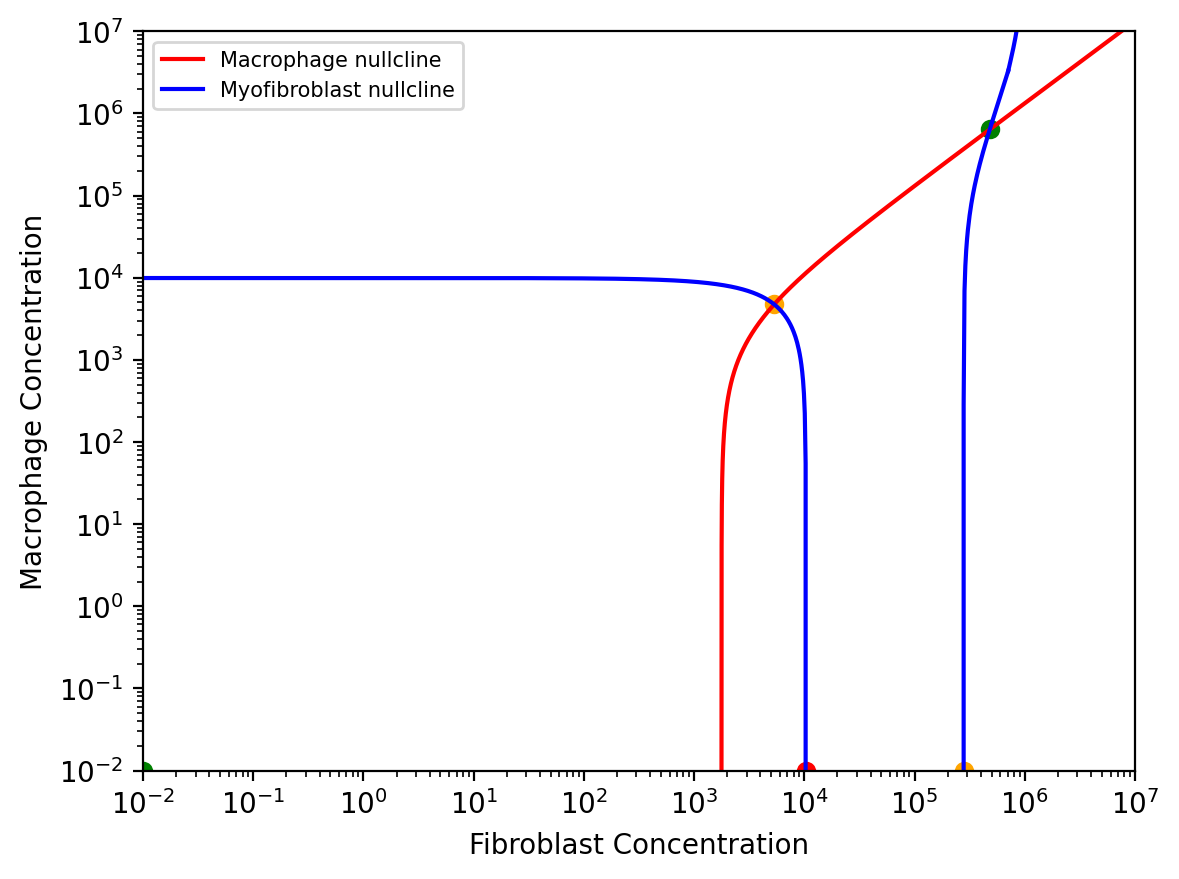

In [5]:
### Nullclines
FM_space = np.logspace(-2, 7, 10**4)
Fnull1 = np.logspace(-2, 5.7, 10**3)
Fnull2 = np.logspace(5.85, 5.95, 10**3)
Fnull3 = np.logspace(6.05, 7, 10**3)
xsmooth1 = [10**5.7, 10**5.85]
ysmooth1 = [sys_1.nullclines_F(pt)[1] for pt in xsmooth1]
plt.plot(xsmooth1, ysmooth1, 'b')
plt.plot(sys_1.nullclines_M(FM_space)[0], sys_1.nullclines_M(FM_space)[1], 'r', label = 'Macrophage nullcline')
plt.plot(sys_1.nullclines_F(Fnull1)[0], sys_1.nullclines_F(Fnull1)[1], 'b', label = 'Myofibroblast nullcline')
plt.plot(sys_1.nullclines_F(Fnull2)[0], sys_1.nullclines_F(Fnull2)[1], 'b')
plt.plot(sys_1.nullclines_F(Fnull3)[0], sys_1.nullclines_F(Fnull3)[1], 'b')
plt.legend(fontsize=7.5, loc='upper left')  # Adjust as needed    plt.show()

lims([0.01, max(Fnull3)],(0.01, max(FM_space)))
plt.xlabel("Fibroblast Concentration")
plt.ylabel("Macrophage Concentration")
logax()
plot_fp(ptx,pty,colors,labels)
plt.show()


0.01,0.01,green,stable (attractor)
10339.24,0.01,red,unstable (repellor)
278801.55,0.01,orange,saddle (mixed stability)
5328.84,4741.06,orange,saddle (mixed stability)
481389.27,639488.3,green,stable (attractor)


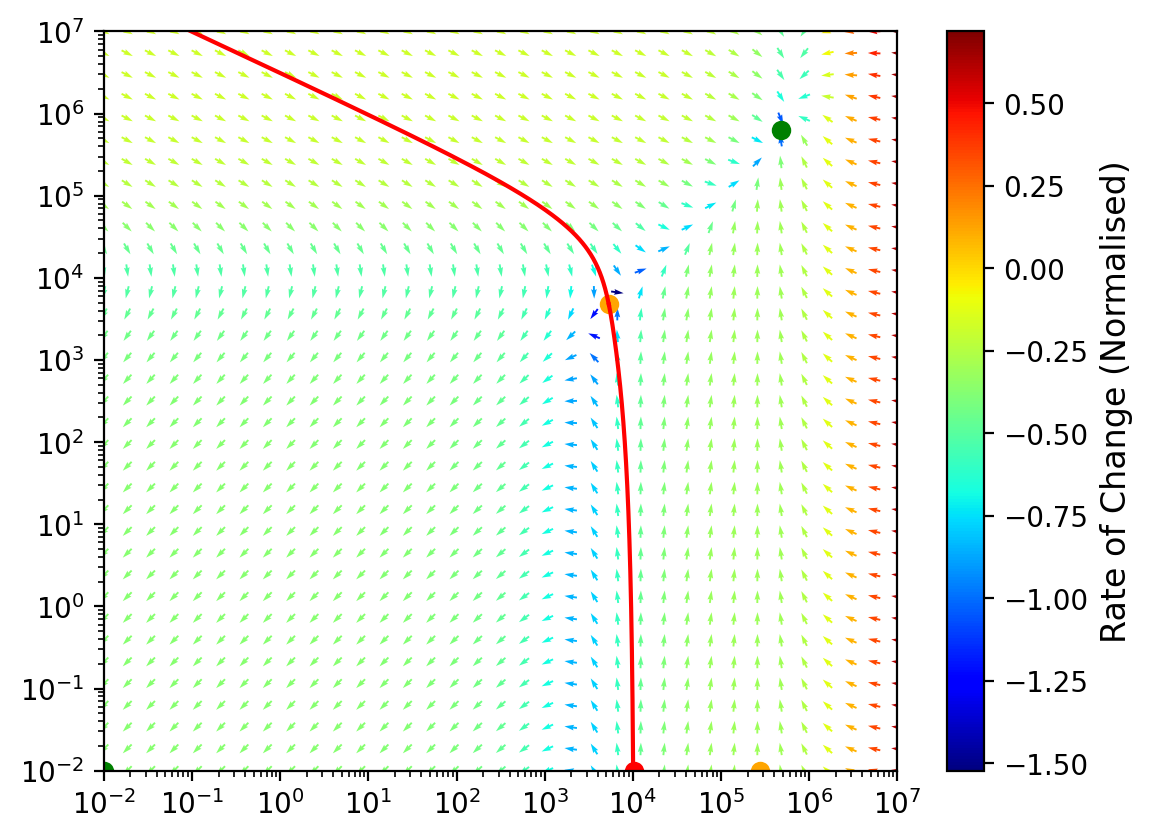

In [6]:
### Quiver
# define a grid and compute direction at each point
x = np.logspace(-2, 7, 35) #np.linspace(0, xmax, nb_points)
y = np.logspace(-2, 7, 35) #np.linspace(0, ymax, nb_points)

X1 , Y1  = np.meshgrid(x, y)                       # create a grid

DY1, DX1 = np.vectorize(lambda M, F: sys_1.change_in_m_f(M, F), otypes=[float, float])(Y1, X1)    
DX1 = DX1/X1
DY1 = DY1/Y1
M = (np.hypot(DX1, DY1))                           # Norm of the growth rate 
M[ M == 0] = 1.                                 # Avoid zero division errors 
DX1 /= M                                        # Normalize each arrows
DY1 /= M
log_M = np.log10(M+1e-9)
Q = plt.quiver(X1, Y1, DX1, DY1, log_M, pivot='mid', cmap=plt.cm.jet)
cbar = plt.colorbar()
cbar.set_label('Rate of Change (Normalised)', fontsize=12)  # Add a label to the colorbar
plot_sep(fixed_pts)
logax()
lims()
plot_fp(ptx,pty,colors,labels)
plt.show()

0.01,0.01,green,stable (attractor)
10339.24,0.01,red,unstable (repellor)
278801.55,0.01,orange,saddle (mixed stability)
5328.84,4741.06,orange,saddle (mixed stability)
481389.27,639488.3,green,stable (attractor)


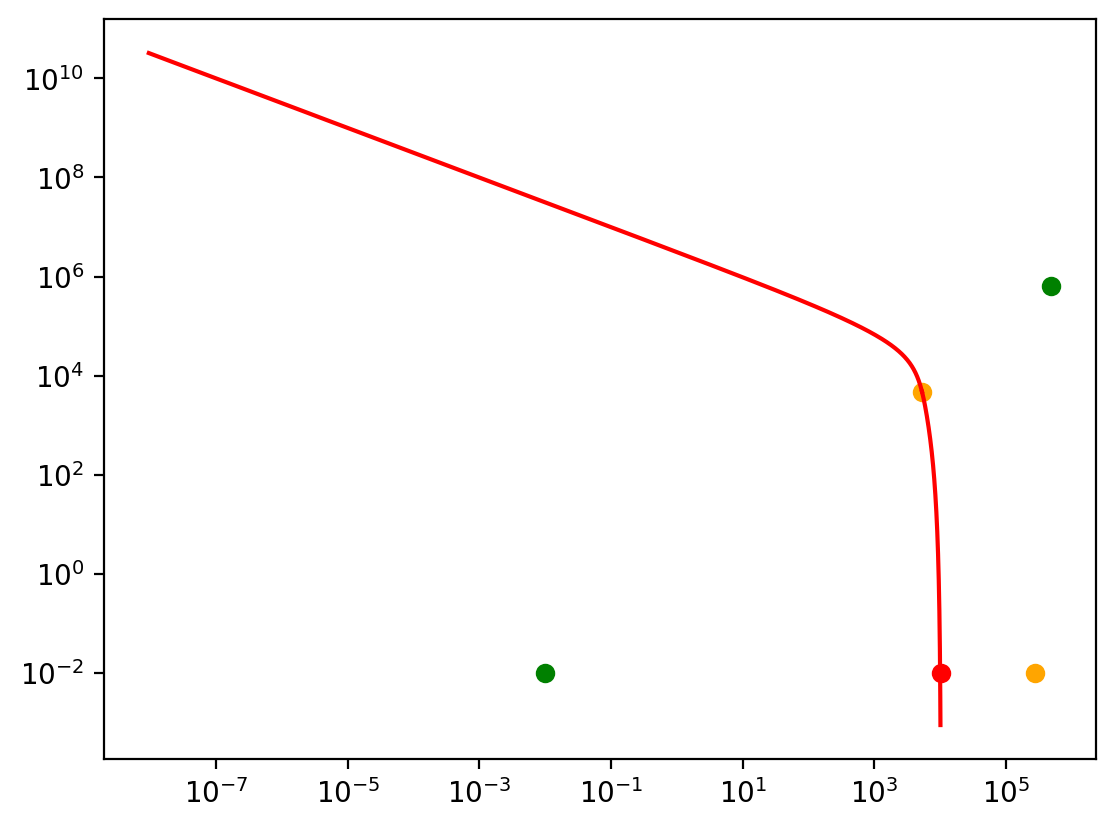

In [7]:

plot_sep(fixed_pts)
logax()
lims
plot_fp(ptx,pty,colors,labels)
plt.show()

0.01,0.01,green,stable (attractor)
10339.24,0.01,red,unstable (repellor)
278801.55,0.01,orange,saddle (mixed stability)
5328.84,4741.06,orange,saddle (mixed stability)
481389.27,639488.3,green,stable (attractor)


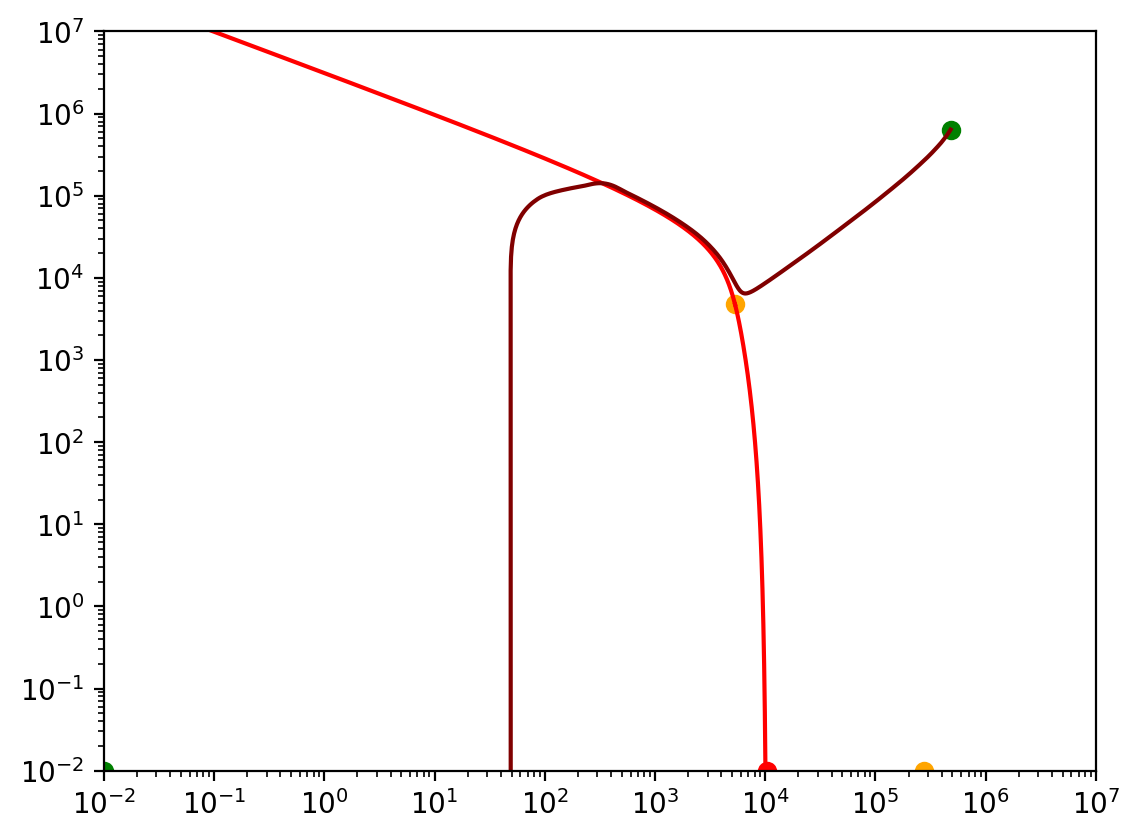

In [8]:



plot_sep(fixed_pts)
fixed_pts_nons = fixed_pts
logax()
lims()
plot_fp(ptx,pty,colors,labels)
pulses = [(0,5,10**4.8),(2,5,-1e4)]
plot_trajectories(pulses)
plt.show()



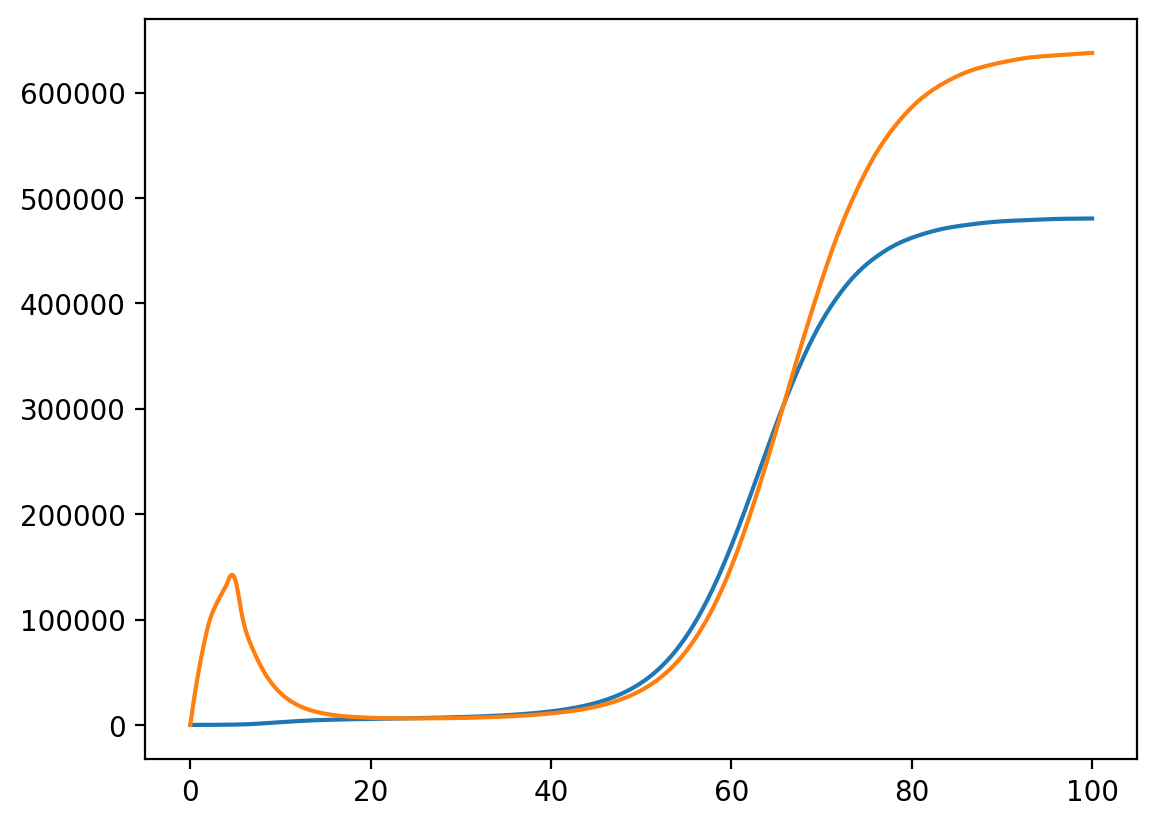

In [9]:
t = np.linspace(0, 100,  1000)
run1_state = [0,0,0,0]
pulses_1 = [(0,5,10**4.8),(2,6,-1e4)]#,(70,130,-10**5)]
#pulses_2 = [(0,5,10**4),(10,15,10**4),(20,25,10**4),(30,35,10**4),(40,45,10**4)]
pulses_2 = [(0,5,10**4.8),(1,4,-1e4)]
#intitial conditions, start with small amount of F or only M population changes
X0 = np.array([0, 50])
X1 = sys_1.solve_constant_injury(t,X0,pulses_1)
plt.plot(X1.t,X1.y[1],label='Myofibroblast, Later Treatment')
plt.plot(X1.t,X1.y[0],label='Macrophage, Later Treatment')
plt.show()

## Model with senescence
### 2D plots


In [10]:
min2day = 24*60 

initial_state_fsm = spm.state_fsm(10, 10, 10, 10, 10)  # Initial cell populations, M, F, P, C, S
    
initial_params_fsm = spm.params_fsm(lam1=0.9, lam2=0.8, mu1=0.3, mu2=0.3, K=1e6, k1=1e9,k2=1e9,
                                beta1=470 * min2day,beta2=70 * min2day,beta3=240 * min2day,
                                alpha1=940 *min2day,alpha2=510 *min2day, gamma=2,
                                  n=0.003,h=50, r=24, q=1e4)  # Parameters for the model
sys_s1 = fsm.fibrosis_senescence_model(initial_params_fsm,initial_state_fsm)

Fixed points calculated
[0.01, 5328.06, 481389.5] [1.0, 4741.81, 639489.61]
0.01,1.0,purple,Saddle
5328.06,4741.81,purple,Saddle
481389.5,639489.61,red,Stable


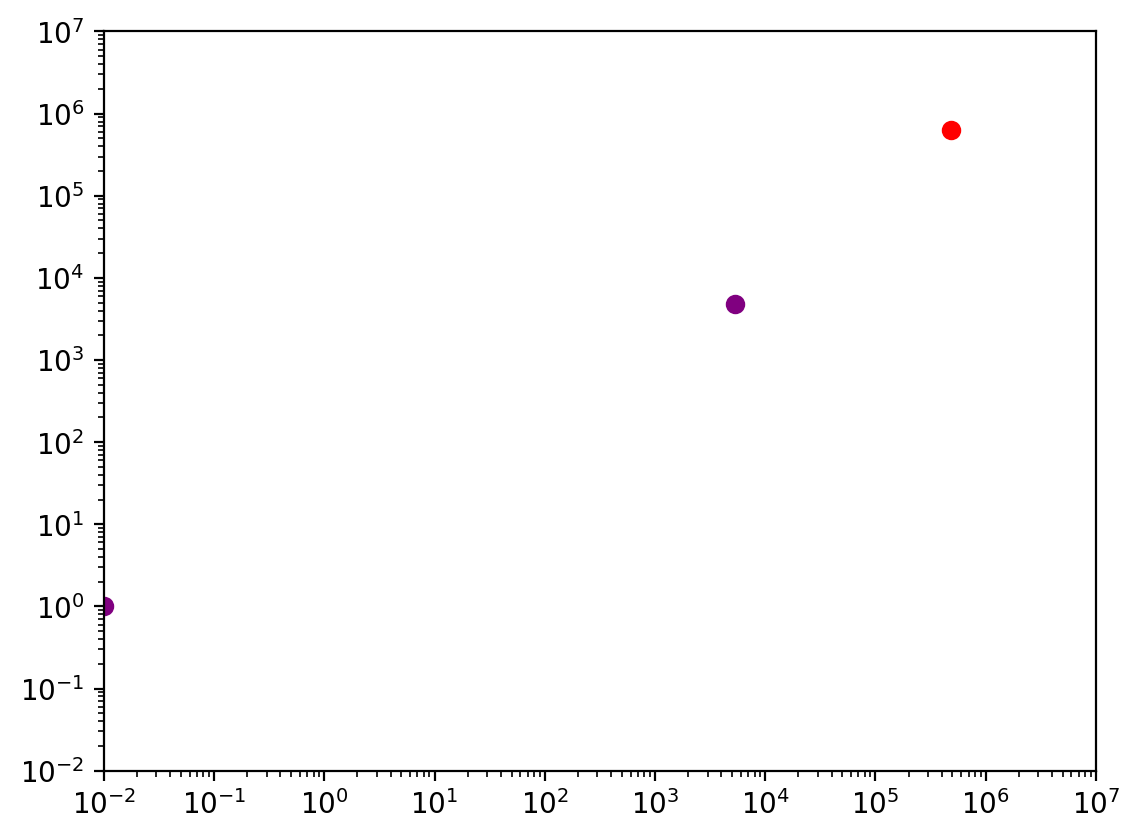


--- Quiver Field Check at Fixed Points ---
[0] M = 1.00e+00, F = 1.00e-02 → |V| = 5.70e+00  (✗)
[1] M = 4.74e+03, F = 5.33e+03 → |V| = 5.70e+00  (✗)
[2] M = 6.39e+05, F = 4.81e+05 → |V| = 5.70e+00  (✗)


In [11]:
fixed_S = 100

# Run sweep and get classifications using the new function
fixed_pts, meta = sys_s1.sweep_fixed_S(
    [-2, 7], [-2, 7],
    fixed_S=fixed_S,
    classify=True,
    method='dynamics',
    perturb=True
)

# Collect results for plotting
ptx, pty = [], []
labels = []
colors = []

for i, (M, F, S) in enumerate(fixed_pts):  # each fp is now a full [M,F,S]
    verdict = meta[i]['verdict']

    # Colour and label based on verdict
    if "stable" in verdict.lower() and "saddle" not in verdict.lower():
        color = 'red'
        label = 'Stable'
    elif "saddle" in verdict.lower():
        color = 'purple'
        label = 'Saddle'
    else:
        color = 'blue'
        label = 'Unstable'

    ptx.append(F)
    pty.append(M)
    colors.append(color)
    labels.append(label)

print("Fixed points calculated")
print(ptx, pty)

plot_fp(ptx,pty,colors,labels)
lims()
plt.show()
def check_quiver_field_at_fixed_points(fixed_pts, model, fixed_S, tol=1e-3):
    """
    Evaluate the quiver field (dM, dF) at the fixed point locations.

    Parameters:
        fixed_pts : list of [M, F] fixed point coordinates
        model     : instance of fibrosis_senescence_model
        fixed_S   : value of S used in the slice/quiver plot
        tol       : tolerance below which the velocity is considered ≈ 0

    Prints out the velocity magnitude at each point.
    """
    print("\n--- Quiver Field Check at Fixed Points ---")
    for i, (M, F,_) in enumerate(fixed_pts):
        dM, dF, _ = model.change_in_m_f(M, F, fixed_S)
        norm = np.hypot(dM, dF)
        flag = "✓" if norm < tol else "✗"
        print(f"[{i}] M = {M:.2e}, F = {F:.2e} → |V| = {norm:.2e}  ({flag})")
check_quiver_field_at_fixed_points(fixed_pts, sys_s1, 2000)

0.01,1.0,purple,Saddle
5328.06,4741.81,purple,Saddle
481389.5,639489.61,red,Stable
[0. 1. 0.] [-6.32177868e-05 -1.60700589e-03]
sep_pos M range: -2312.6209325760206 4741.81
sep_pos F range: 5376.971289620592 6811.3075198000815


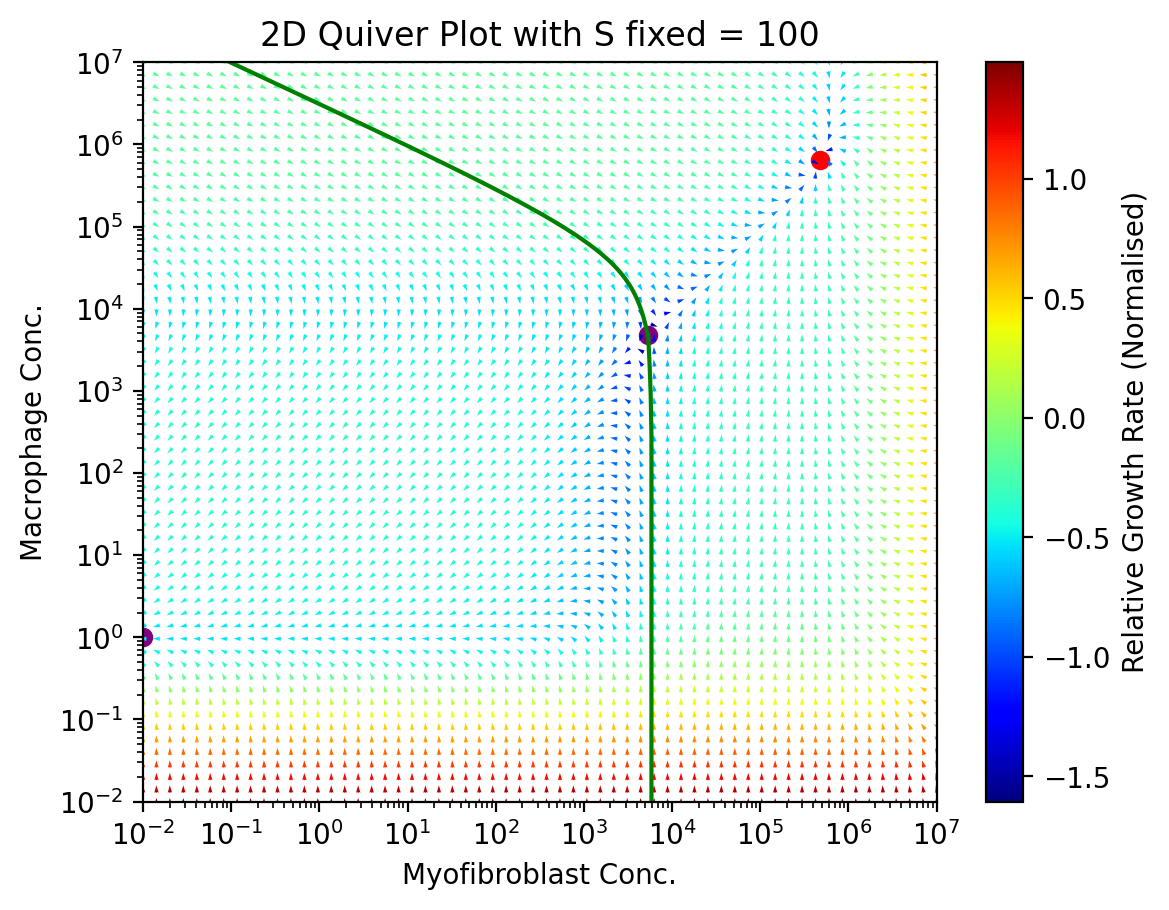

In [16]:
M_vals = np.logspace(-2,7,60) # Myofibroblast concentrations (x-axis)
F_vals = np.logspace(-2,7,60)  # Macrophage concentrations (y-axis)
# M_vals = np.linspace(0,20,40)
# F_vals = np.linspace(0,20,40)

#fixed_S = 2000  # Set a biologically relevant fixed value for Senescent cells
plot_fp(ptx,pty,colors,labels)
lims()
logax()
sys_s1.plot_2D_quiver_field_fixed_S(M_vals, F_vals, fixed_S,x_label="Myofibroblast Conc.",y_label="Macrophage Conc.")
sep_pos_2,sep_neg_2 = sys_s1.separatrix(np.linspace(0,75,150),(pty[1],ptx[1],2000),epsilon=50)

print("sep_pos M range:", np.min(sep_pos_2[0]), np.max(sep_pos_2[0]))
print("sep_pos F range:", np.min(sep_pos_2[1]), np.max(sep_pos_2[1]))

plt.plot(sep_pos_2[1],sep_pos_2[0],'g')
plt.plot(sep_neg_2[1],sep_neg_2[0],'g')

#plot_sep(fixed_pts_nons)

plt.show()

0.01,1.0,purple,Saddle
5328.06,4741.81,purple,Saddle
481389.5,639489.61,red,Stable


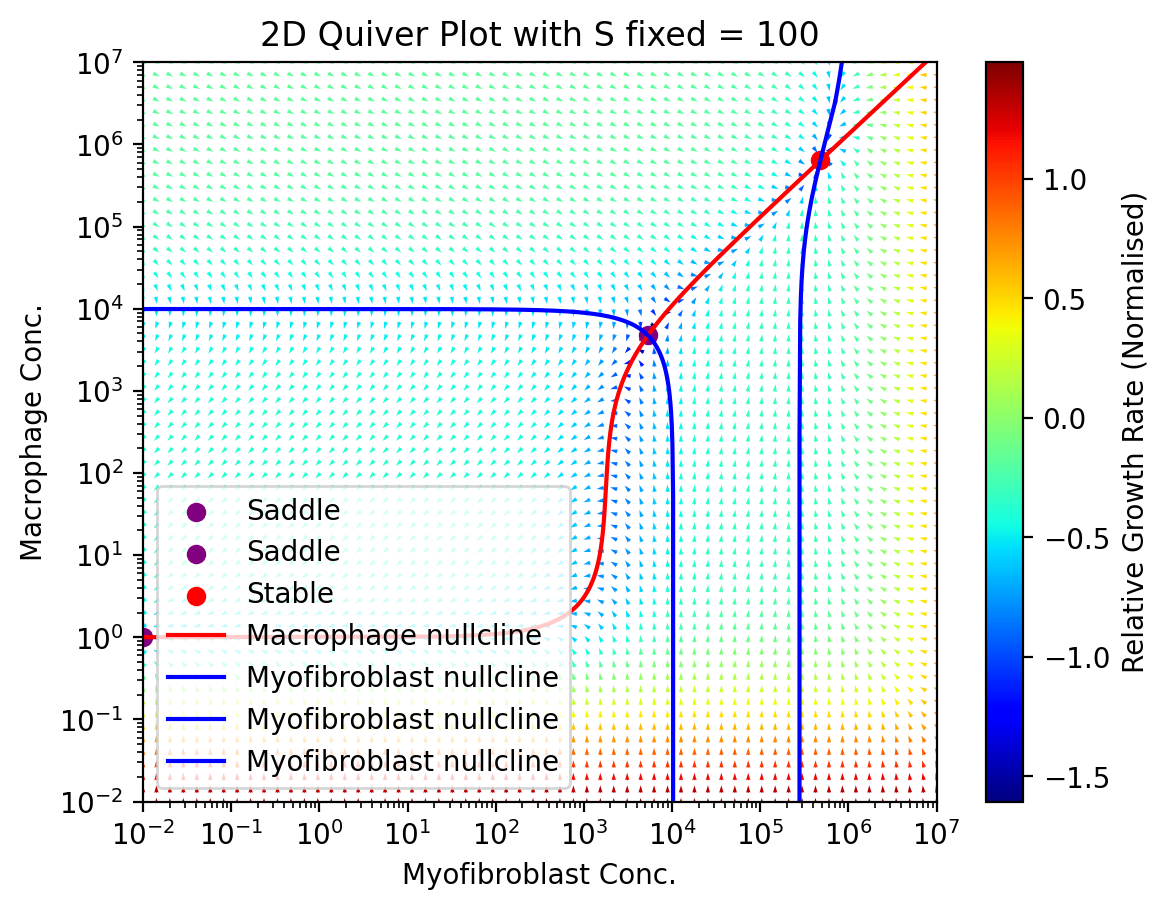

Min F: 0.0036938830452185375
Any NaNs near axis? False
⚠️ Invalid term at M=1.00e-02: term = -2.97e+01
⚠️ Invalid term at M=1.02e-02: term = -2.91e+01
⚠️ Invalid term at M=1.04e-02: term = -2.85e+01
⚠️ Invalid term at M=1.06e-02: term = -2.79e+01
⚠️ Invalid term at M=1.09e-02: term = -2.73e+01
⚠️ Invalid term at M=1.11e-02: term = -2.67e+01
⚠️ Invalid term at M=1.13e-02: term = -2.62e+01
⚠️ Invalid term at M=1.16e-02: term = -2.56e+01
⚠️ Invalid term at M=1.18e-02: term = -2.51e+01
⚠️ Invalid term at M=1.21e-02: term = -2.46e+01
⚠️ Invalid term at M=1.23e-02: term = -2.41e+01
⚠️ Invalid term at M=1.26e-02: term = -2.36e+01
⚠️ Invalid term at M=1.28e-02: term = -2.31e+01
⚠️ Invalid term at M=1.31e-02: term = -2.26e+01
⚠️ Invalid term at M=1.34e-02: term = -2.21e+01
⚠️ Invalid term at M=1.37e-02: term = -2.17e+01
⚠️ Invalid term at M=1.39e-02: term = -2.12e+01
⚠️ Invalid term at M=1.42e-02: term = -2.08e+01
⚠️ Invalid term at M=1.45e-02: term = -2.04e+01
⚠️ Invalid term at M=1.48e-02: te

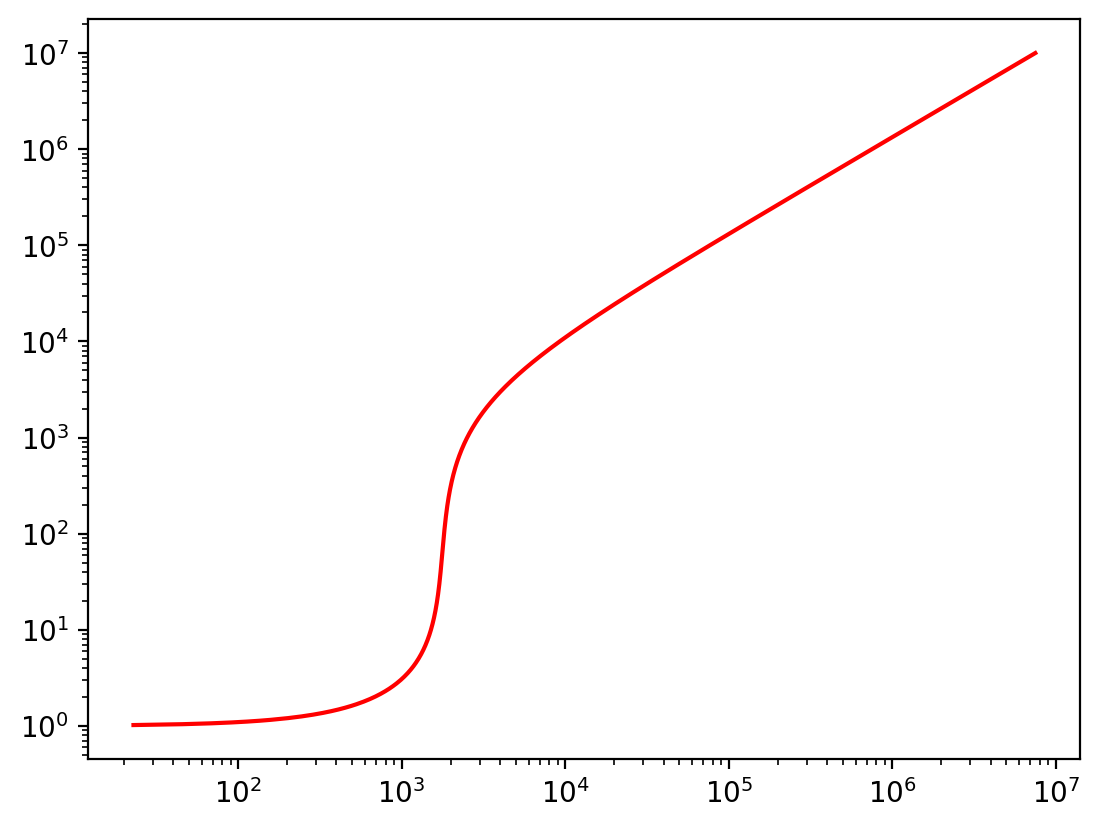

In [13]:
FM_space = np.logspace(-2, 7, 10**3)
Fnull1 = np.logspace(-2, 5.7, 10**3)
Fnull2 = np.logspace(5.85, 5.95, 10**3)
Fnull3 = np.logspace(6.05, 7, 10**3)

# Smooth bridge across pole gap
xsmooth1 = [10**5.7, 10**5.85]
ysmooth1 = [sys_s1.nullclines_F(pt)[1] for pt in xsmooth1]

# Plot quiver field + fixed points
sys_s1.plot_2D_quiver_field_fixed_S(
    M_vals, F_vals, fixed_S,
    x_label="Myofibroblast Conc.",
    y_label="Macrophage Conc."
)
plot_fp(ptx, pty, colors, labels)

# Macrophage nullcline (red)
M_vals_M, F_vals_M = sys_s1.nullclines_M_fixed_S(FM_space, S_fixed=fixed_S)
plt.plot(F_vals_M, M_vals_M, 'r', label='Macrophage nullcline')


# Myofibroblast nullcline (blue), skip S since it's not used
for Frange in [Fnull1, Fnull2, Fnull3]:
    Fvals = Frange
    Mvals = [sys_s1.nullclines_F(f)[1] for f in Fvals]
    plt.plot(Fvals, Mvals, 'b', label='Myofibroblast nullcline')

# Bridge over vertical pole gap
plt.plot(xsmooth1, ysmooth1, 'b')

# Final plot cosmetics
logax()
lims()
plt.legend()
plt.show()
print("Min F:", np.nanmin(F_vals_M))
print("Any NaNs near axis?", np.any(np.isnan(F_vals_M[:10])))

M_vals_full = np.logspace(-2, 7, 1000)
good_M, bad_M = sys_s1.debug_nullcline_M_S(M_vals_full, S_fixed=fixed_S)

# Now rerun your plotting only on `good_M`
Fvals = sys_s1.nullclines_M_fixed_S(good_M, S_fixed=fixed_S)[1]
plt.plot(Fvals, good_M, 'r', label='Macrophage nullcline')
logax()
plt.show()